# Modelling Change - Project

## Topic: Gradient Descent

> `numerical` `optimisation`

Gradient descent is a general method for finding minima of functions taught is widely used in many fields.
Write out the equations for a simple gradient descent method and code an implementation in Python.
Locate the minima of an example function who's min you can find using the analytically (that is, as we did
in lectures and tutorials). Investigate how the convergence is affected by:

1. step size or other parameters in the algorith
2. the initial starting point

### Author: 

**Name:** Jonathon Belotti

**Student ID:** 13791607

## Overview

This report details the mathematics and computer code implementation of the _Gradient Descent_ optimisation method, and investigates the behaviour of the optimisation process when subject to variance in algorithm paramaters ('step size', iteration number) and variance in the initial starting point. 

### Report Structure

1. [**Introduction to the Pure-Python3 Implementation.**](#1.-Introduction-to-the-Pure-Python3-Implementation)
2. [**Introduction to the Gradient Descent method.**](#2.-Introduction-to-the-Gradient-Descent-Method)
3. [**Convergence.**](#3.-Convergence)
5. [**References**](#References)
6. [**Appendix**](#Appendix)

### 1. Introduction to the Pure-Python3 Implementation

To assist in the exploration and communication of the Gradient Descent optimisation technique, a 'from scratch' [pure-Python](https://stackoverflow.com/a/52461357/4885590) implementation of the gradient descent algorithm has been written and is used throughout. It is a 'standalone module', and imports no third-party code. The implementation targets usefulness in learning, not performance, but is fast enough for practical example.

To reduce implementation complexity and length, not all differentiable functions are supported by the implementation. Supported functions include:

- [Polynomial functions](https://en.wikipedia.org/wiki/Polynomial)


The implementation is wholly contained in one Python3 module, `gradient_descent`, and it is available at: https://github.com/thundergolfer/modelling_change

In [66]:
from typing import Mapping

import gradient_descent  # Assumes gradient_descent.py is on PYTHONPATH. For module implementation see appendix.

**Variables** become components in expressions and are used in the differentiation functions. They don't do much else.

```python
x = Variable("x")
```

**Expressions** can be evaluated at a point in function space, eg $(x=1, y=2, z=4)$ and can be differentiated with respect to a reference variable. 

`Expression` is a base class for `ConstantExpression`, `PolynomialExpression`, and `Multiply`.

```python
class Expression:
    def diff(self, ref_var: Optional[Variable] = None) -> Optional["Expression"]:
        raise NotImplementedError

    def evaluate(self, point: Point) -> float:
        raise NotImplementedError
```

**MultiVariableFunctions** are created by specifying their inputs, `variables`, and composing `Expression` objects by 
addition (subtraction is handled by negative coefficients on expressions).

We can get the gradient of a function and evaluated it at a point in function space, just like `Expression` objects.

```python
class MultiVariableFunction:
    """
    MultiVariableFunction support the composition of expressions by addition into a
    function of multiple real-valued variables.

    Partial differentiation with respect to a single variable is supported, as is
    evaluation at a Point, and gradient finding.
    """

    def __init__(self, variables: Set[Variable], expressions: List[Expression]): ...

    def gradient(self) -> GradientVector: ...

    def diff(self, ref_var: Variable) -> "MultiVariableFunction": ...

    def evaluate(self, point: Point) -> float: ...
```

### 2. Introduction to the Gradient Descent Method

Gradient Descent is an iterative optimization process that can be used effectively to find local mimina of differentiable functions, particulary when those functions are convex. When the output of a differentiable function under some set of inputs can be framed as a _cost_, the minimization of this _cost function_ becomes an optimization problem to which the Gradient Descent process can be applied.

The "Deep Neural Networks" revolution that swept through the 2010s has its foundation in the simple single-layer neural networks first published in the 1980s, and those simple networks were optimized through gradient descent. Thus, a first lesson in understanding today's hottest technological field, Deep Neural Networks, involves going right back to the start and understanding the basic Gradient Descent optimization process.

#### 2.1 A Function's Gradient

In order to minimise a function's value, we need to ascertain which way we should nudge its inputs to decrease the output value, and we have to be sure than a series of decreases will eventually lead to a minimum (local or global). For differentiable functions, the first-derivative of a function can be the way.

For a function of a single variable, $f(x)$, the rate of change at some value $x=a$ is given by the first-derivative $f'(x)$. In the case of $f(x) = x^2 + x$, we know that:

$$f'(x) = 2x + 1$$

and thus at $f'(1) = 2(1) + 1 = 3$ the function is increasing in output value 'to the right' and decreasing 'to the left'. At $f'(-1) = 2(-1) + 1 = -1$ the function is decreasing in output value 'to the right' and increasing 'to the left;. 

In either case, we know from the first-derivative which direction to nudge $x$, until we reach $f'(1/2) = 2*(1/2) + 1 = 0$ and we've reached the critical point.


But for a multi-variable function there are multiple ways in which to influence the output value and thus multiple dimensions along which a we could change inputs. How can we extend our understanding of the direction of function decrease beyond 'left and right' and into 3-dimensions and more? We use partial derivatives.


If $z = f(x, y)$, then we have a multi-variable function with partial derivatives:
    
$$f_x(x_0, y_0) = \lim_{h \to 0}\frac{f(x_0+h, y_0) - f(x_0, y_0)}{h}$$

$$f_y(x_0, y_0) = \lim_{h \to 0}\frac{f(x_0, y_0+h) - f(x_0, y_0)}{h}$$

with each capturing the rate-of-change with respect to a single variable in our multi-variable function.

In the $x,y$ plane, we can imagine being at some point $(x_0,y_0)$ and nudging away from that point in the plane by the vector $\mathbf{u} = \langle a, b \rangle $. 

Now not restricted to moving 'left and right' in the x-axis or 'up and down' the y-axis, we have a **Directional Derivative** of $f$ at $(x_0,y_0)$.

$$D_uf(x_0, y_0) = \lim_{h \to 0}\frac{f(x_0 + ha, y_0+hb) - f(x_0, y_0)}{h}$$

More intuitively, we can consider that nudge as being of length $h$ at some angle $\theta$ (capturing direction). Thus our $a$ and $b$ are $\cos{\theta}$ and $\sin{\theta}$ respectively, and $\mathbf{u} = \langle a, b \rangle $ is a vector of length 1.

In fact, any differentiable function of $x$ and $y$ has a directional derivative in a direction of $\mathbf{u}$ and this relationship can be expressed as:

$$D_uf(x, y) = f_x(x, y)a + f_y(x, y)b$$

**To prove this.**

Define a function $g$ of the single variable $h$ as

$$
\begin{align}
g(h) & = f(x_0 + ha, y_0+hb) \\
\end{align}
$$


By definition of the derivative:

$$
\begin{align}
g'(0) & = \lim_{h \to 0}\frac{g(h) - g(0)}{h} \\
& = \lim_{h \to 0}\frac{f(x_0+ha, y_0+hb) - f(x_0, y_0)}{h}\\
& = D_uf(x_0, y_0)
\end{align}
$$

Writing $x = x_0 + ha$ and $y = y_0 + hb$ we get $g(h) = f(x, y)$ and 

$$
\begin{align}
g'(h) & = \frac{\partial f}{\partial x}\frac{\partial x}{\partial h} + \frac{\partial f}{\partial y}\frac{\partial y}{\partial h} \\
& = f_x(x, y)a + f_y(x, y)b \\
& = D_uf(x_0, y_0)
\end{align}
$$

Substituting in $h=0$ then $x$ and $y$ become $x = x_0$, $y = y_0$, so:

$$
\begin{align}
g'(0) & = f_x(x, y)a + f_y(x, y)b \\
 & = f_x(x_0, y_0)a + f_y(x_0, y_0)b \\
& = D_uf(x_0, y_0)
\end{align}
$$

Thus:

$$D_uf(x, y) = f_x(x, y)a + f_y(x, y)b$$


This relationship between partial derivatives and a directional nudges in each input dimension generalises beyond 2 dimensions, and can be compactly represented by _vectorising_ the combination of the partial derivatives and an input.

$$
\begin{align}
D_uf(x,y) & = f_x(x, y)a + f_y(x, y)b \\
 & = \langle f_x(x,y), f_y(x, y) \rangle \cdot \langle a, b \rangle \\
 & = \langle f_x(x,y), f_y(x, y) \rangle \cdot \mathbf{u} \\
\end{align}
$$

**In the `gradient_descent` library, we can calculate the gradient vector from a `MultiVariableFunction`. For the function:**

$$f(x,y) = x^2 + y^2 - 2x - 6y + 14$$

In [49]:
x = gradient_descent.Variable("x")
y = gradient_descent.Variable("y")
f = gradient_descent.MultiVariableFunction(
    variables={x, y},
    expressions=[
        gradient_descent.PolynomialExpression(variable=x, coefficient=1, exponent=2),
        gradient_descent.PolynomialExpression(variable=y, coefficient=1, exponent=2),
        gradient_descent.PolynomialExpression(variable=x, coefficient=-2, exponent=1),
        gradient_descent.PolynomialExpression(variable=y, coefficient=-6, exponent=1),
        gradient_descent.ConstantExpression(real=14.0),
    ],
)

f.gradient()

{y: 2y¹ + -6, x: 2x¹ + -2}

#### 2.2 Steepest Descent

Now able to determine the gradient vector of a function, capturing the rate of change along each dimension of a function, the question becomes in which 'direction' to go to 'descend' or decrease the function's value?.

$$\nabla_{u} f(x_0,y_0) = \mathbf{u} \cdot f(x_0, y_0)$$ 

Firstly, if the gradient is zero

$$\nabla_{u} f(x_0,y_0) = 0$$ 

then the directional gradient is zero in every direction. This would be the end of our descent. But for a non-zero gradient, then the gradient itself is the direction that maximises the dot product.

$$\max \nabla f(x_0, y_0) \cdot \mathbf{u} = \frac{\nabla f(x_0, y_0)}{\lvert \nabla f(x_0, y_0) \rvert}$$

![alt text](vector_projection.png "Title")

This is actually great, because in order to descend fastest from some point $f(x_0, y_0)$ we don't need to calculate which direction is best, the direction of the gradient is the best direction.

#### 2.3 Gradient Descent - Iterating Towards the Bottom

Now with a method to calculate the direction of maximum descent from a point $\mathbf{a}$ in a function's input space, we are very close to creating the _Gradient Descent_ optimisation process.

Given a differentiable multi-variable function $f(\mathbf{x})$, with $\mathbf{x}$ being a vector of inputs $\langle x, y, z, ... \rangle$, then we know:

**At some point $\mathbf{a} \in \mathbf{x}$, $f(\mathbf{x})$ decreases _fastest_ in the direction of the negative gradient:** $-\nabla \mathbf{f(a)}$

In the Python library `gradient_descent`, we can calculate this:

In [50]:
f_grad = f.gradient()

print(f"Gradient: {f_grad}")

a: gradient_descent.Point = {
    x: -1,
    y: 1,
}

f_grad_a: Mapping[gradient_descent.Variable, float] = {
    var: grad_elem.evaluate(a)
    for var, grad_elem
    in f_grad.items()
}
    
print("Gradient of f(x, y) @ point 'a'")
print(f_grad_a)

Gradient: {y: 2y¹ + -6, x: 2x¹ + -2}
Gradient of f(x, y) @ point 'a'
{y: -4, x: -4}


#### 2.4  Analytical vs. Iterative

Now, understanding the process, we are ready to run Gradient Descent in Python. The optimisation problem we'll solve is minimising:

$$cost= f(x,y) = x^2 + y^2 - 2x - 6y + 14$$

We can solve this analytically, which will be useful in validating the Python implementation:

$$
\begin{align}
f_x(x, y) & = 2x + 0 - 2 - 0 + 0 \\
f_x(x, y) & = 2x - 2\\
\\
f_y(x, y) & = 0 + 2y - 0 - 6 + 0 \\
f_y(x, y) & = 2y - 6
\end{align}
$$

Solving...

$$
\begin{align}
f_x(x, y) & = 2x - 2 = 0 \\
2x - 2 & = 0 \\
2x & = 2 \\
x & = 1 \\
\\
f_y(x, y) & = 2y - 6 = 0 \\
2y - 6 & = 0 \\
2y & = 6 \\
y & = 3 \\
\end{align}
$$

So $f(x, y)$ has a critical point at $(1, 3)$ and we can show graphically that this critical point is a minimum:

In [51]:
import sympy
import numpy as np
import matplotlib.pyplot as plt

Text(0.5, 0, 'z')

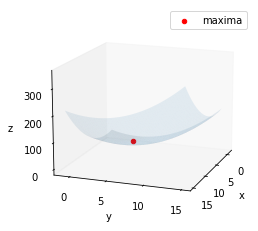

In [52]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Create boundaries of f(x,y)
x = np.linspace(-1,15)
y = np.linspace(-1,15)

# Create 2D domain of f(x,y)
xf, yf = np.meshgrid(x,y)

# Discrete version of f(x,y) over 2D domain
fxy = (xf**2) + (yf**2) - (2*xf) - (6*yf) + 14

# Plot our function to be optimised f(x,y)
ax.plot_surface(xf, yf, fxy, alpha=0.1)
ax.view_init(15, 20)

# Plot extrema
x_extrema = np.array([1])
y_extrema = np.array([3])
z_extrema = (x_extrema**2) + (y_extrema**2) - (2*x_extrema) - (6*y_extrema) + 14

ax.scatter(x_extrema, y_extrema, z_extrema,  color='r', label='maxima')

ax.grid(False)
ax.legend()
# plt.locator_params(nbins=6) # Amount of numbers per axis
# Label our axes
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

**Now let's solve the same problem iteratively using the Python implementation of the Gradient Descent algorithm:**

The core of the iterative gradient descent process is nice and simple:

$$ \mathbf{a}_{n+1} = \mathbf {a}_{n}-\gamma \nabla f(\mathbf {a} _{n})$$


$$f(\mathbf{a_0}) \ge f(\mathbf{a_1}) \ge f(\mathbf{a_1}) \ge f(\mathbf{a_2}) \ge f(\mathbf{a_3}) ...$$

This process has 4 clear inputs:

1. The function
2. The initial starting point, $\mathbf{a_0}$
3. The step size, $\gamma$ (gamma)
4. The number of iterations

In [53]:
minimum_val, minimum_point = gradient_descent.gradient_descent(
        gamma=0.1,
        max_iterations=5000,
        f=f,
    )
print("\nResu")
print(f"Min Value: {minimum_val}")
print(f"Min Location: {minimum_point}")

Iteration 0. Current min estimate: {y: 1.4, x: 0.2}
Iteration 100. Current min estimate: {y: 2.999999999674074, x: 0.9999999998370371}
Iteration as not changed value. Stopping early.

Resu
Min Value: 4.000000000000002
Min Location: {y: 2.999999999999999, x: 0.9999999999999998}


Success! The answers are not exact because of [floating-point arithmetic error](https://docs.oracle.com/cd/E19957-01/806-3568/ncg_goldberg.html), but $(1, 3)$ is correct.

We can re-run the function and no matter which values are randomly assigned to the initial starting point, the process converges to the correct result.

### 3. Convergence Behaviour

Having demonstrated gradient descent convergence of a simple convex function, let's investigate convergence behaviour
on different functions when the parameters of the convergence process are manipulated.

#### 3.1 Changing Max Iterations

Clearly we have have a relationship between the function's gradient, the step size, and the number of iterations that can cause nonconvergence when max iterations is limited. 

We want the step size to be small enough such that the monotonic series is stable in its convergence to a minima,
but 'small enough' assumes a sufficient series length. By severely limiting iterations, we can prevent convergence even on the simple function we've observed earlier.

In [54]:
minimum_val, minimum_point = gradient_descent.gradient_descent(
        gamma=0.01,
        max_iterations=5,
        f=f,
    )
print("\nResults:")
print(f"Min Value: {minimum_val}")
print(f"Min Location: {minimum_point}")

Iteration 0. Current min estimate: {y: 1.04, x: 1.0}

Results:
Min Value: 7.268291227550188
Min Location: {y: 1.1921584064, x: 1.0}


#### 3.2 Changing Step Size

The _Rosenbrock function_ function below was specifically designed to test optimization functions like gradient descent. The global minima of the function is $(1, 1)$ but is difficult to reach this minima because it is in a _very_
shallow valley.

$$f(x,y)=(1-x)^2+100(y-x^2)^2$$

alternate form

$$100 x^4 - 200 x^2 y + x^2 - 2 x + 100 y^2 + 1$$

We can use `matplotlib` to visualise the shallowness of the area in which the $(1, 1)$ global minima resides.
Due to the sensitivity of our contour bands, the function's value area to be unchanging in a large parabolic region
containing the minima. In fact, the area contains a _very slight_ decline.

Text(0.5, 1.0, 'Contours of f(x,y)')

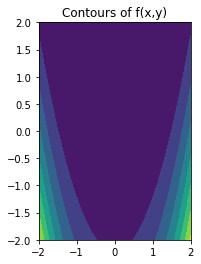

In [59]:
delta = 0.001
x = np.arange(-3.0, 3.0, delta)
y = np.arange(-2.0, 2.0, delta)

X, Y = np.meshgrid(x, y)

Z1 = np.exp(-X**2 - Y**2)
Z2 = np.exp(-(X - 1)**2 - (Y - 1)**2)
Z = (Z1 - Z2) * 2

x = np.linspace(-2,2)
y = np.linspace(-2,2)

# Create our grid of points
xv, yv = np.meshgrid(x,y)
ax = plt.subplot(1,2,1) 

# Make a contour plot that is filled with color.
ax.contourf(xv,yv, (1 - xv)**2+ 100*(yv - (xv**2))**2)
ax.set_title('Contours of f(x,y)')

Attempting gradient descent on this function, we do not the global minimum even after a large number of iterations,
_but we get close_.

In [65]:
x = gradient_descent.Variable("x")
y = gradient_descent.Variable("y")
f = gradient_descent.MultiVariableFunction(                                                    # f(x, y) =
    variables={x, y},
    expressions=[
        gradient_descent.PolynomialExpression(variable=x, coefficient=100, exponent=4),        # 100x^4 -
        gradient_descent.Multiply(                                                             # 200x^2y +
            a=gradient_descent.PolynomialExpression(variable=x, coefficient=-200, exponent=2),
            b=gradient_descent.PolynomialExpression(variable=y, coefficient=1, exponent=1),
        ),  
        gradient_descent.PolynomialExpression(variable=x, coefficient=1, exponent=2),          # x^2 -
        gradient_descent.PolynomialExpression(variable=x, coefficient=-2, exponent=1),         # 2x +
        gradient_descent.PolynomialExpression(variable=y, coefficient=100, exponent=2),        # 100y^2 +
        gradient_descent.ConstantExpression(real=1.0),                                         # 1
    ],
)

f.gradient()

# The grad descent process on this function is quite sensitive to initial point. 
# If started too far away from minima, the gradients 'explode' and convergence does not occur.
initial_points = [
    {x: 1, y: 1},
    {x: 1.1, y: 1.1},
]

MAX_ITERATIONS = 5000  # How big does this need to be to achieve convergence???

for i_p in initial_points:
    minimum_val, minimum_point = gradient_descent.gradient_descent(
        gamma=0.00001,
        max_iterations=MAX_ITERATIONS,
        initial_point=i_p,
        f=f,
    )
    print("\nResults:")
    print(f"--- Min Value: {minimum_val}")
    print(f"--- Min Location: {minimum_point}\n\n")

Iteration as not changed value. Stopping early.

Results:
--- Min Value: 0.0
--- Min Location: {x: 1.0, y: 1.0}


Iteration 0. Current min estimate: {x: 1.099514, y: 1.1002200000000002}
Iteration 100. Current min estimate: {x: 1.0712464694571409, y: 1.1131643728354728}
Iteration 200. Current min estimate: {x: 1.0622711298885563, y: 1.1173091383534954}
Iteration 300. Current min estimate: {x: 1.0593220496848512, y: 1.118642060274933}
Iteration 400. Current min estimate: {x: 1.058333909285996, y: 1.1190531918362856}
Iteration 500. Current min estimate: {x: 1.0579923675519987, y: 1.1191596339557224}
Iteration 600. Current min estimate: {x: 1.057864974526982, y: 1.1191650939215858}
Iteration 700. Current min estimate: {x: 1.0578086137988398, y: 1.1191370615264575}
Iteration 800. Current min estimate: {x: 1.0577758294294612, y: 1.1190979241649124}
Iteration 900. Current min estimate: {x: 1.0577508749438052, y: 1.1190551112832905}
Iteration 1000. Current min estimate: {x: 1.0577285241727554,

#### 3.3 Changing initial starting points

For functions with _multiple_ local minima, it matters which initial starting point we use, as gradient descent has
no mathematical mechanism of exploring multiple local minima.

The function below has two minima, at $(1, 1)$ and $(-1, -1)$. Gradient descent can find either, depending on initial point of descent.

$$f(x, y) = x^4 + y^4 - 4xy + 1$$

In [43]:
x = gradient_descent.Variable("x")
y = gradient_descent.Variable("y")
f = gradient_descent.MultiVariableFunction(                                                    # f(x, y) =
    variables={x, y},
    expressions=[
        gradient_descent.PolynomialExpression(variable=x, coefficient=1, exponent=4),          # x^4 +
        gradient_descent.PolynomialExpression(variable=y, coefficient=1, exponent=4),          # y^4 -
        gradient_descent.Multiply(                                                             # 4xy +
            a=gradient_descent.PolynomialExpression(variable=x, coefficient=-4, exponent=1),
            b=gradient_descent.PolynomialExpression(variable=y, coefficient=1, exponent=1),
        ),  
        gradient_descent.ConstantExpression(real=1.0),                                         # 1
    ],
)

# The grad descent process on this function is quite sensitive to initial point. 
# If started too far away from minima, the gradients 'explode' and convergence does not occur.
initial_points = [
    {x: 1, y: 1},
    {x: -1, y: -1},
    {x: -1.5, y: -1.5},
    {x: 1.1, y: 1.2},
]

for i_p in initial_points:
    minimum_val, minimum_point = gradient_descent.gradient_descent(
        gamma=0.1,
        max_iterations=50000,
        initial_point=i_p,
        f=f,
    )
    print("\nResults:")
    print(f"--- Min Value: {minimum_val}")
    print(f"--- Min Location: {minimum_point}")

Iteration as not changed value. Stopping early.

Results:
--- Min Value: -1.0
--- Min Location: {x: 1.0, y: 1.0}
Iteration as not changed value. Stopping early.

Results:
--- Min Value: -1.0
--- Min Location: {x: -1.0, y: -1.0}
Iteration 0. Current min estimate: {x: -0.75, y: -0.75}
Iteration as not changed value. Stopping early.

Results:
--- Min Value: -1.0
--- Min Location: {x: -1.0, y: -1.0}
Iteration 0. Current min estimate: {x: 1.0475999999999999, y: 0.9488000000000001}
Iteration as not changed value. Stopping early.

Results:
--- Min Value: -1.0
--- Min Location: {x: 1.0, y: 1.0}


### Conclusion

In this report we've demonstrated the core components of the gradient descent optimization process, in both Python and equations. Convergence has been demonstrated on simple polynomials and more complicated polynomials that can demonstrate how careful parameter tuning of the gradient descent process can be necessary to ensure convergence, even on convex functions.

## References

*  RUMELHART, David E.; HINTON, Geoffrey E.; WILLIAMS, Ronald J. (1986). "Learning representations by back-propagating errors". Nature. 323 (6088): 533–536. doi:10.1038/323533a0. S2CID 205001834 -http://www.cs.utoronto.ca/~hinton/absps/naturebp.pdf
* STEWART, J. (2019). "Calculus: concepts and contexts". Boston, MA, USA, Cengage.
* SANDERSON, G. (2018). "Why the gradient is the direction of steepest ascent". https://www.youtube.com/watch?v=TEB2z7ZlRAw

## Appendix

The full `gradient_descent` implementation is available online at [github.com/thundergolfer/modelling_change/](https://github.com/thundergolfer/modelling_change/), but it has also been copied in below:

In [46]:
"""
Pure-Python3 implementation of Gradient Descent (https://en.wikipedia.org/wiki/Gradient_descent).
Written for educational/learning purposes and not performance.

Completed as part of the UTS course '35512 - Modelling Change' (https://handbook.uts.edu.au/subjects/35512.html).
"""
import random
from typing import List, Mapping, Optional, Dict, Set, Tuple


# Used to make chars like 'x' resemble typical mathematical symbols.
def _italic_str(text: str) -> str:
    return f"\x1B[3m{text}\x1B[23m"


def _superscript_exp(n: str) -> str:
    return "".join(["⁰¹²³⁴⁵⁶⁷⁸⁹"[ord(c) - ord('0')] for c in str(n)])


class Variable:
    """
    A object representing a mathematical variable, for use in building expressions.

    Usage: `x = Variable("x")`
    """
    def __init__(self, var: str):
        if len(var) != 1 or (not var.isalpha()):
            raise ValueError("Variable must be single alphabetical character. eg. 'x'")
        self.var = var

    def __repr__(self):
        return _italic_str(self.var)

    def __eq__(self, other):
        """Overrides the default implementation"""
        if isinstance(other, Variable):
            return self.var == other.var
        return False

    def __key(self):
        return self.var

    def __hash__(self):
        return hash(self.__key())


# An element of some set called a space. Here, that 'space' will be the domain of a multi-variable function.
Point = Dict[Variable, float]


class Expression:
    def diff(self, ref_var: Optional[Variable] = None) -> Optional["Expression"]:
        raise NotImplementedError

    def evaluate(self, point: Point) -> float:
        raise NotImplementedError


class ConstantExpression(Expression):
    """
    ConstantExpression is a single real-valued number.
    It cannot be parameterised and its first-derivative is always 0 (None).
    """

    def __init__(self, real: float):
        super().__init__()
        self.real = real

    def diff(self, ref_var: Optional[Variable] = None) -> Optional[Expression]:
        return None

    def evaluate(self, point: Point) -> float:
        return self.real

    def __repr__(self):
        return str(self.real)


class PolynomialExpression(Expression):
    """
    An expression object that support evaluation and differentiation of single-variable polynomials.
    """
    def __init__(
            self,
            variable: Variable,
            coefficient: float,
            exponent: int
    ):
        super().__init__()
        self.var = variable
        self.coefficient = coefficient
        self.exp = exponent

    def diff(self, ref_var: Optional[Variable] = None) -> Optional[Expression]:
        if ref_var and ref_var != self.var:
            return None
        if self.exp == 1:
            return ConstantExpression(real=self.coefficient)
        return PolynomialExpression(
            variable=self.var,
            coefficient=self.coefficient * self.exp,
            exponent=self.exp - 1,
        )

    def evaluate(self, point: Point) -> float:
        return (
                self.coefficient *
                point[self.var] ** self.exp
        )

    def __repr__(self):
        return f"{self.coefficient}{self.var}{_superscript_exp(str(self.exp))}"


class Multiply(Expression):
    def __init__(self, a: PolynomialExpression, b: PolynomialExpression):
        self.a = a
        self.b = b

    def diff(self, ref_var: Optional[Variable] = None) -> Optional["Expression"]:
        if not ref_var:
            raise RuntimeError("Must pass ref_var when differentiating Multiply expression")
        if self.a.var == ref_var:
            diff_a = self.a.diff(ref_var=ref_var)
            if not diff_a:
                return None
            else:
                return Multiply(a=diff_a, b=self.b)
        elif self.b.var == ref_var:
            diff_b = self.b.diff(ref_var=ref_var)
            if not diff_b:
                return None
            else:
                return Multiply(a=self.a, b=diff_b)
        else:
            return None  # diff with respect to some non-involved variable is 0

    def evaluate(self, point: Point) -> float:
        return self.a.evaluate(point) * self.b.evaluate(point)

    def __repr__(self):
        return f"({self.a})({self.b})"


GradientVector = Dict[Variable, "MultiVariableFunction"]


class MultiVariableFunction:
    """
    MultiVariableFunction support the composition of expressions by addition into a
    function of multiple real-valued variables.

    Partial differentiation with respect to a single variable is supported, as is
    evaluation at a Point, and gradient finding.
    """

    def __init__(self, variables: Set[Variable], expressions: List[Expression]):
        self.vars = variables
        self.expressions = expressions

    def gradient(self) -> GradientVector:
        grad_v: GradientVector = {}
        for v in self.vars:
            grad_v[v] = self.diff(ref_var=v)
        return grad_v

    def diff(self, ref_var: Variable) -> "MultiVariableFunction":
        first_partial_derivatives: List[Expression] = []
        for expression in self.expressions:
            first_partial_diff = expression.diff(ref_var=ref_var)
            if first_partial_diff:
                first_partial_derivatives.append(first_partial_diff)
        return MultiVariableFunction(
            variables=self.vars,
            expressions=first_partial_derivatives,
        )

    def evaluate(self, point: Point) -> float:
        return sum(
            expression.evaluate(point)
            for expression
            in self.expressions
        )

    def __repr__(self):
        return " + ".join([str(e) for e in self.expressions])


def gradient_descent(
    gamma: float,
    max_iterations: int,
    f: MultiVariableFunction,
    initial_point: Optional[Point] = None,
) -> Tuple[float, Point]:
    """
    Implements Gradient Descent (https://en.wikipedia.org/wiki/Gradient_descent) in pure-Python3.6+ with
    no external dependencies.

    :param gamma: 'step size', or 'learning rate'
    :param max_iterations: Maximum number of steps in descent process.
    :param f: A differentiable function off multiple real-valued variables.
    :param initial_point: Optionally, a place to start the descent process
    :return: A tuple of first a local minimum and second the point at which minimum is found.
    """
    if gamma <= 0:
        raise ValueError("gamma value must be a positive real number, γ∈ℝ+")

    iterations_per_logline = 100
    a: Point = {}
    f_grad = f.gradient()

    if not initial_point:
        for v in f.vars:
            a[v] = random.randrange(4)
    else:
        a = initial_point
    for i in range(max_iterations):
        # Calculate function's gradient @ point `a`
        grad_a: Mapping[Variable, float] = {
            var: grad_elem.evaluate(a)
            for var, grad_elem
            in f_grad.items()
        }
        # update estimate of minimum point
        a_next = {
            var: current - (gamma * grad_a[var])
            for var, current
            in a.items()
        }
        a_prev = a
        a = a_next

        if a_prev == a:
            print("Iteration as not changed value. Stopping early.")
            break
        if i % iterations_per_logline == 0:
            print(f"Iteration {i}. Current min estimate: {a}")
    return f.evaluate(a), a


def main() -> None:
    x = Variable("x")
    y = Variable("y")

    # Test variable comparisons
    ##########################
    assert Variable("x") == Variable("x")
    assert Variable("x") != Variable("y")
    assert Variable("y") != Variable("x")
    assert Variable("y") != Variable("z")

    # Test gradient evaluations of Expressions
    ##########################################
    # ConstantExpressions
    assert ConstantExpression(real=0.0).diff() is None
    assert ConstantExpression(real=4.5).diff() is None
    # PolynomialExpression
    poly1 = PolynomialExpression(
        variable=Variable("x"),
        coefficient=2,
        exponent=4,
    )
    poly1_grad1 = poly1.diff()
    assert poly1_grad1.var == Variable("x")
    assert poly1_grad1.coefficient == 8
    assert poly1_grad1.exp == 3
    poly1_grad2 = poly1.diff(ref_var=Variable("y"))
    assert poly1_grad2 is None

    # Test function evaluation
    ##########################
    x = Variable("x")
    y = Variable("y")
    # f = 3x + y^2
    f1 = MultiVariableFunction(
        variables={x, y},
        expressions=[
            PolynomialExpression(variable=x, coefficient=3, exponent=1),
            PolynomialExpression(variable=y, coefficient=1, exponent=2),
        ],
    )
    assert f1.evaluate(point={x: 1.0, y: 1.0}) == 4
    assert f1.evaluate(point={x: 1.0, y: 2.0}) == 7
    # Test function gradient
    g = f1.gradient()
    assert str(g[x]) == "3"

    # Test Multiply
    ##########################
    a = PolynomialExpression(variable=x, coefficient=3, exponent=1)
    b = PolynomialExpression(variable=y, coefficient=1, exponent=2)
    a_times_b = Multiply(a=a, b=b)
    result = a_times_b.evaluate(point={x: 2.0, y: 4.0})
    assert result == (6 * 16)
    result = a_times_b.evaluate(point={x: 3.0, y: 5.0})
    assert result == 225
    # Test diff on multiplication expression
    a_times_b_diff = a_times_b.diff(ref_var=x)
    assert a_times_b_diff.evaluate(point={x: 1.0, y: 5.0}) == 75


if __name__ == "__main__":
    main()